<a href="https://colab.research.google.com/github/Shihori/AI/blob/main/sec6_cnn_230529.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

編集部注：2023年5月29日最終更新．コードの一部がお手元の書籍と異なる可能性がございます．正誤・更新情報は弊社ウェブサイトの[本書詳細ページ](https://www.yodosha.co.jp/jikkenigaku/book/9784758122634/index.html)をご参照ください．

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/sec6/
%ls -a

Mounted at /content/drive
/content/drive/MyDrive/sec6
cell_images/                           kaggle_dl_unet_230529.ipynb  sec6_segment_230529.ipynb
cell-images-for-detecting-malaria.zip  kaggle.json
kaggle_dl_cnn_230529.ipynb             sec6_cnn_230529.ipynb


In [2]:
!pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5248 sha256=98323c35530359819fc267d7a3d85087fc437544cbbffa46c981b18adde83d45
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import os
import scipy
import random
from tqdm import tqdm
import glob

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
from torchvision import models
from torchvision import datasets
from torchvision import transforms as transforms

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp


In [4]:
path = "/content/drive/MyDrive/sec6" #フォルダパス
im_fd = "/cell_images/" #上のパスからImageのあるフォルダの参照

/content/drive/MyDrive/sec6/cell_images/Uninfected/C47P8thinOriginalOlympusCX21_IMG_20150717_174750_cell_137.png


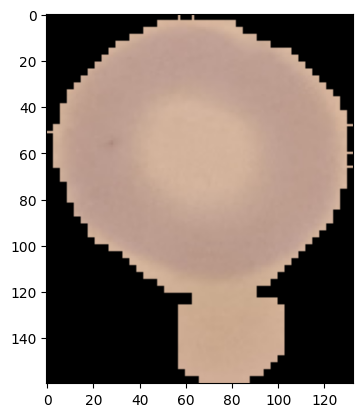

In [5]:
folder = ['Uninfected','Parasitized']
file0 = glob.glob(path + im_fd + folder[0] +"/*.png")[0]
print(file0)
image = Image.open(file0) # 画像ファイルの読み込み
plt.imshow(image) #表示

In [6]:
np.array(image) #画像データを配列として表示

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Get cpu or gpu device for training.
print(f"Using {device} device")

Using cuda device


In [8]:
image_size = 128; #Imageサイズの指定

In [9]:
SEED = 42

def seed_fix(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms = True
    torch.backends.cudnn.deterministic = True

    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_fix(SEED)
generator = torch.Generator()
generator.manual_seed(SEED)

In [10]:
folder = ['Uninfected','Parasitized']
X = [];
y = [];
usenumber = 1000
for i,folname in enumerate(folder):
    files1 = glob.glob(path + im_fd + folname +"/*.png"); #フォルダ内のファイル名を取得
    f_number = len(files1) #randomに一部のデータのみ抽出するためのコード
    files1, files2=torch.utils.data.random_split(files1,[usenumber,f_number - usenumber])
    for j, file in enumerate(tqdm(files1)):
        outcome = i
        image = Image.open(file) # 画像ファイルの読み込み
        image = image.convert("RGB") # RGBモードに変換
        image = image.resize((image_size, image_size)) # リサイズ
        data = np.asarray(image) # 画像を配列に変換
        X.append(data); # 複数枚を１つの配列に保存
        y.append(outcome)  #正解ラベルをyとして保存

100%|██████████| 1000/1000 [03:08<00:00,  5.30it/s]


In [11]:
#配列データへの変換 ４次元のデータとして(画像枚数，RGBの層，画像の高さ，画像の横幅)になるように次元を入れ替え
X = np.array(X).astype(np.float32).transpose(0,3,1,2)/255
y = np.array(y)

In [12]:
Nall = X.shape[0]

In [13]:
tensor_X = torch.tensor(X, dtype=torch.float32) #Tensor型として変換
tensor_y = torch.tensor(y, dtype=torch.int64) #Tensor型として変換

In [14]:
dataset = torch.utils.data.TensorDataset(tensor_X,tensor_y)# 目的変数と入力変数をまとめてdatasetに変換
n_train = int(Nall * 0.7) # Training データ数
n_val = int(Nall * 0.2)   # Validation データ数
n_test = Nall - n_train - n_val # Test データ数
train_x, val_x, test_x = torch.utils.data.random_split(dataset, [n_train, n_val,n_test]) # データセットの分割
print("train =",n_train,",validation =",n_val,",Test =",n_test)

train = 1400 ,validation = 400 ,Test = 200


In [15]:
batch_size = 64 #バッチサイズの指定
train_dataloader = DataLoader(train_x, batch_size=batch_size, shuffle=True)  # data loaderとして指定
val_dataloader   = DataLoader(val_x,   batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_x,  batch_size=1, shuffle=False)

In [16]:
class CNN(nn.Module):
    def __init__(self, input_shape=(3,128,128),output_size=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.CNN_outshape = self._get_conv_output(input_shape)
        self.linear = nn.Linear(self.CNN_outshape, output_size)
    def _get_conv_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = self._forward_features(dummy_x)
        CNN_outshape = x.flatten(1).size(1)
        return CNN_outshape
    def _forward_features(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.dropout(x)
        x = self.flatten(x)
        return x
    def forward(self, x):
        x = self._forward_features(x)
        x = self.linear(x.flatten(1))
        return x
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)


In [17]:
transform = transforms.Compose([
    transforms.RandomResizedCrop((image_size,image_size)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(degrees=[-7.5, 7.5])
    ]
) #Data augumentation

In [18]:
#最適化
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.005)

def train(train_loader): #Training
    model.train()
    running_loss = 0
    correct = 0
    total = len(train_loader.dataset)
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        #data augumentation
        #images = transform(images)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = outputs.max(1, keepdim=True)[1]
        labels = labels.view_as(predicted)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

def valid(test_loader): #Validation
    model.eval()
    running_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

#空の配列
acc_list = []
loss_list = []
val_loss_list = []
val_acc_list = []

In [19]:
nepoch = 300

#Fitting
for epoch in range(nepoch):
    loss, acc = train(train_dataloader)
    val_loss, val_acc = valid(val_dataloader)
    print('epoch %d, loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss,acc, val_loss, val_acc))
    loss_list.append(loss)
    acc_list.append(acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 0.6938 acc: 0.4843 val_loss: 0.6933 val_acc: 0.4800
epoch 1, loss: 0.6938 acc: 0.4729 val_loss: 0.6933 val_acc: 0.4975
epoch 2, loss: 0.6930 acc: 0.5014 val_loss: 0.6932 val_acc: 0.4975
epoch 3, loss: 0.6931 acc: 0.4993 val_loss: 0.6931 val_acc: 0.4975
epoch 4, loss: 0.6926 acc: 0.5150 val_loss: 0.6929 val_acc: 0.4975
epoch 5, loss: 0.6926 acc: 0.5179 val_loss: 0.6927 val_acc: 0.4950
epoch 6, loss: 0.6925 acc: 0.5307 val_loss: 0.6925 val_acc: 0.5250
epoch 7, loss: 0.6917 acc: 0.5721 val_loss: 0.6924 val_acc: 0.5500
epoch 8, loss: 0.6922 acc: 0.5393 val_loss: 0.6923 val_acc: 0.5075
epoch 9, loss: 0.6915 acc: 0.5571 val_loss: 0.6921 val_acc: 0.5325
epoch 10, loss: 0.6914 acc: 0.5236 val_loss: 0.6921 val_acc: 0.5000
epoch 11, loss: 0.6910 acc: 0.5186 val_loss: 0.6920 val_acc: 0.5000
epoch 12, loss: 0.6909 acc: 0.5686 val_loss: 0.6915 val_acc: 0.5625
epoch 13, loss: 0.6907 acc: 0.5764 val_loss: 0.6912 val_acc: 0.5850
epoch 14, loss: 0.6904 acc: 0.5864 val_loss: 0.6910 val_ac

In [20]:
#modelの保存
torch.save(model, 'model.pt')

In [21]:
#読み込み
model = torch.load('model.pt')

正解率： 91.75 %


Text(0, 0.5, 'acc')

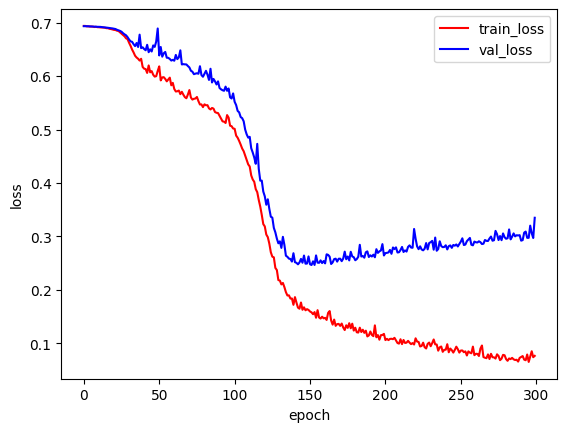

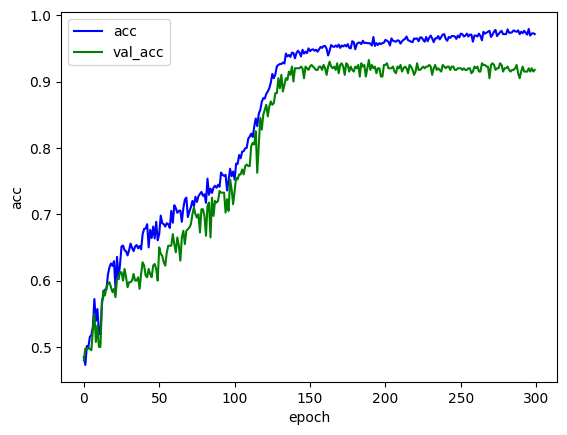

In [22]:
print('正解率：',val_acc_list[-1]*100, '%')

#学習過程の表示
plt.plot(range(nepoch), loss_list, 'r-', label='train_loss')
plt.plot(range(nepoch), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure()
plt.plot(range(nepoch), acc_list, 'b-', label='acc')
plt.plot(range(nepoch), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')

モデル評価：テストデータへの当てはめ

In [23]:
#For Test
def test(test_loader):
    prob = []
    pred = []
    true = []
    model.eval()
    running_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            lprob, predicted = outputs.max(1, keepdim=True)
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
            prob = np.append(prob, scipy.special.expit(torch.Tensor.numpy(outputs[:,1].to('cpu'))))
            pred = np.append(pred, torch.Tensor.numpy(predicted.to('cpu')))
            true = np.append(true, torch.Tensor.numpy(labels.to('cpu')))
    return prob, pred, true

prob, pred, true,  = test(test_dataloader)


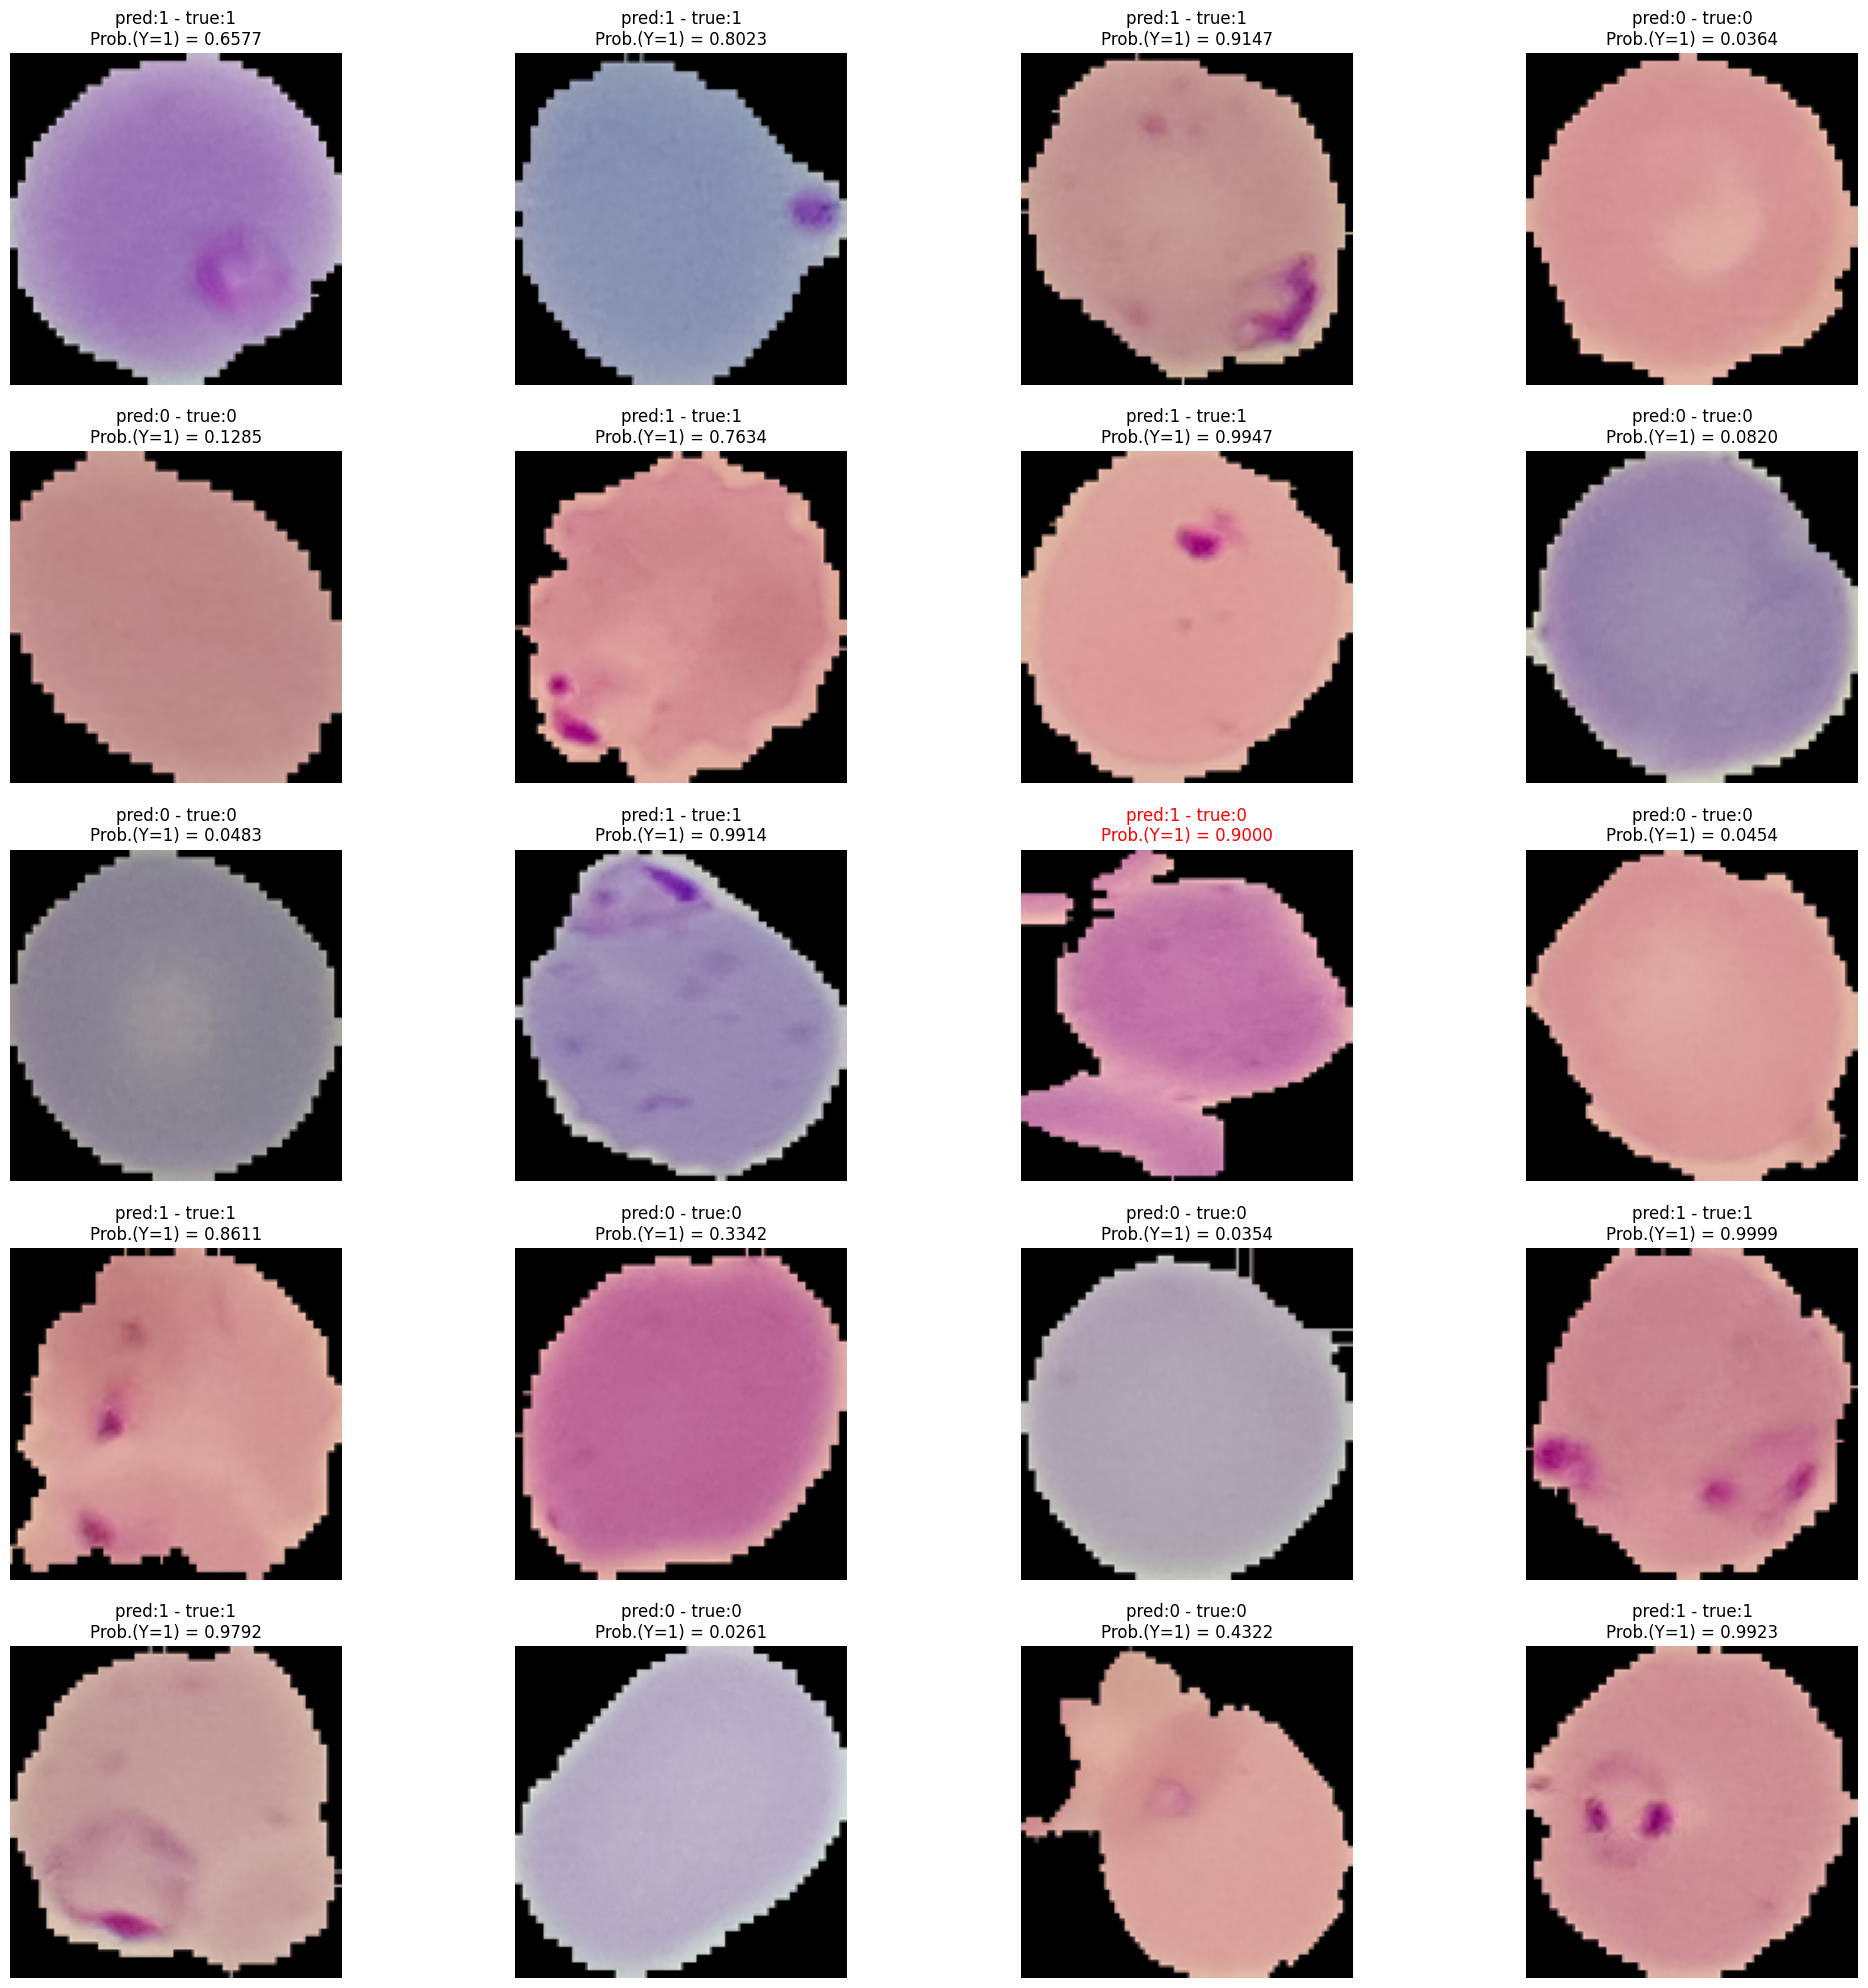

In [24]:
# testデータの画像と予測ラベル・正答ラベル・予測確率を出力
plt.figure(figsize = (25, 25))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.axis("off")
    if pred[i] == true[i]:
        plt.title("pred:"+str(pred[i].astype(np.uint8))+' - '+"true:"+str(true[i].astype(np.uint8))+'\n'+'Prob.(Y=1) = %.4f' % (prob[i]))
    else:
        plt.title("pred:"+str(pred[i].astype(np.uint8))+' - '+"true:"+str(true[i].astype(np.uint8))+'\n'+'Prob.(Y=1) = %.4f' % (prob[i]), color = "red") # 分類が間違っていた場合，赤字で書き込む

    tmp = test_x[i][0].to('cpu').detach().numpy().copy()
    tmp = tmp.transpose(1, 2, 0)
    img_pil = Image.fromarray((tmp*255).astype(np.uint8))
    plt.imshow(img_pil)




In [25]:
#2×2行列に正解不正解まとめる
cmat = confusion_matrix(true, pred)
print(cmat)

#感度特異度の算出
tn, fp, fn, tp = cmat.flatten()

acc = round((tp+tn)/(tp+tn+fp+fn),4)
sen = round(tp/(tp+fn),4)
spe = round(tn/(tn+fp),4)
ppv = round(tp/(tp+fp),4)
npv = round(tn/(tn+fn),4)
print("acc=",acc,"sen=",sen," ,spe=",spe," ,ppv=",ppv," ,npv=",npv)



[[92  4]
 [ 8 96]]
acc= 0.94 sen= 0.9231  ,spe= 0.9583  ,ppv= 0.96  ,npv= 0.92


Cutoff-value: 0.212 Sensitivity: 0.9808 Specificity:  0.9167


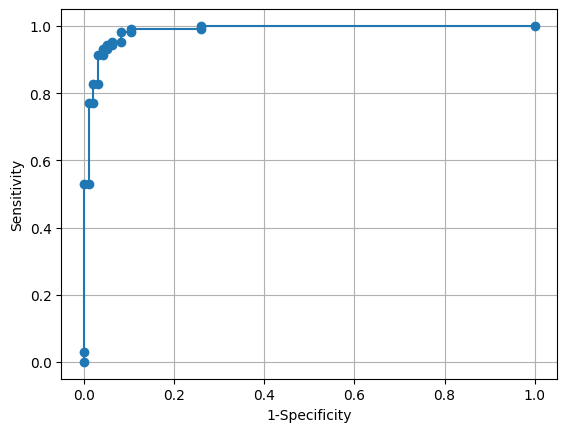

In [26]:
#ROC curve

fpr, tpr, thresholds = roc_curve(true, prob)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid()
#plt.savefig(path+'/roc_curve.png')

Youden_index = tpr-fpr
index = np.where(Youden_index==max(Youden_index))[0][0]

cutoff = thresholds[index]
sensitivity = tpr[index]
specificity = 1 - fpr[index]
print("Cutoff-value:",round(cutoff,4),"Sensitivity:",round(sensitivity,4),"Specificity: ",round(specificity,4))




In [27]:
#!pip install grad-cam -q
#!conda install grad-cam

Grad-CAM

In [28]:
# Grad-CAM

In [29]:
#読み込み
model = torch.load('model.pt')
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)

In [30]:
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)


In [31]:
target_layer = model.conv4[1]

In [32]:
gradcam = GradCAM(model, target_layer)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


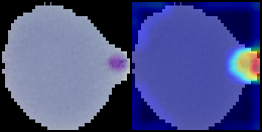

In [33]:
image_number = 1
torch_img = torch.tensor(np.expand_dims(test_x[image_number][0], 0)).to(device) #画像をTorch
images = []
mask, _ = gradcam(torch_img)
heatmap, result = visualize_cam(mask, torch_img)
image0 = torch.squeeze(torch_img,dim=0)
images.extend([image0.cpu(), result])
grid_image = torchvision.utils.make_grid(images, nrow=2)
transforms.ToPILImage()(grid_image)

Finetuning

In [34]:
model = models.vgg16(pretrained=True)# 事前トレーニングされたVGG16モデルを取得
model.classifier[6] = nn.Linear(in_features=4096,out_features=2)   # 入力サイズはデフォルトの4096 出力はデフォルトの1000から2に変更
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #GPUで使用できるように指定
model = model.to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:14<00:00, 39.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [35]:
# 転移学習で学習させるパラメータ
params_to_update = []
update_param_names = ['classifier.6.weight', 'classifier.6.bias']
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False # 出力層以外は勾配計算なし

classifier.6.weight
classifier.6.bias


In [36]:
# 損失関数
criterion = nn.CrossEntropyLoss()
# オプティマイザー
optimizer = torch.optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)



#Trainig用
def train(train_loader):
    model.train()
    running_loss = 0
    correct = 0
    total = len(train_loader.dataset)

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = outputs.max(1, keepdim=True)[1]
        labels = labels.view_as(predicted)
        correct += predicted.eq(labels).sum().item()


    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc



#Validation用
def valid( test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
            #break

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

'''誤差(loss)を記録する空の配列を用意'''
acc_list = []
loss_list = []
val_loss_list = []
val_acc_list = []


In [37]:
nepoch = 50

#学習 1回目の学習は行わず評価のみ
for epoch in range(nepoch):

    if(epoch > 0):
        loss, acc = train(train_dataloader)
    else:
        loss, acc = valid(train_dataloader)

    val_loss, val_acc = valid(val_dataloader)
    print('epoch %d, loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss,acc, val_loss, val_acc))
    loss_list.append(loss)
    acc_list.append(acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 0.7391 acc: 0.5143 val_loss: 0.7568 val_acc: 0.5025
epoch 1, loss: 0.5288 acc: 0.7236 val_loss: 0.3642 val_acc: 0.8425
epoch 2, loss: 0.3719 acc: 0.8393 val_loss: 0.4289 val_acc: 0.7925
epoch 3, loss: 0.3594 acc: 0.8400 val_loss: 0.3277 val_acc: 0.8550
epoch 4, loss: 0.3308 acc: 0.8550 val_loss: 0.3472 val_acc: 0.8500
epoch 5, loss: 0.3479 acc: 0.8493 val_loss: 0.2967 val_acc: 0.8800
epoch 6, loss: 0.3487 acc: 0.8393 val_loss: 0.3894 val_acc: 0.8250
epoch 7, loss: 0.3450 acc: 0.8493 val_loss: 0.3432 val_acc: 0.8475
epoch 8, loss: 0.3297 acc: 0.8493 val_loss: 0.2796 val_acc: 0.9075
epoch 9, loss: 0.3411 acc: 0.8564 val_loss: 0.2922 val_acc: 0.8675
epoch 10, loss: 0.3221 acc: 0.8557 val_loss: 0.3348 val_acc: 0.8500
epoch 11, loss: 0.3237 acc: 0.8650 val_loss: 0.2964 val_acc: 0.8825
epoch 12, loss: 0.3209 acc: 0.8557 val_loss: 0.3022 val_acc: 0.8800
epoch 13, loss: 0.3199 acc: 0.8743 val_loss: 0.3089 val_acc: 0.8625
epoch 14, loss: 0.3161 acc: 0.8557 val_loss: 0.3599 val_ac

In [38]:
#modelの保存
torch.save(model, 'model_finetuning.pt')


正解率： 87.5 %


Text(0, 0.5, 'acc')

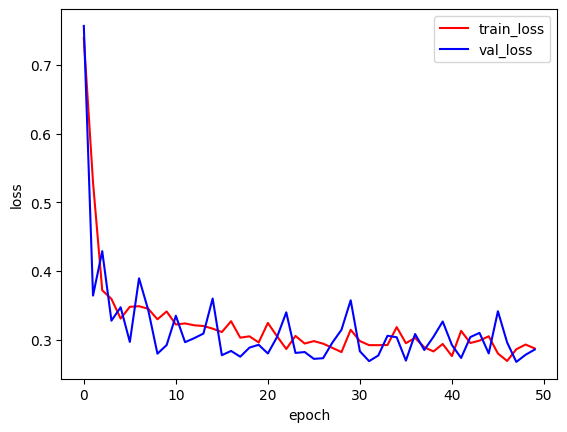

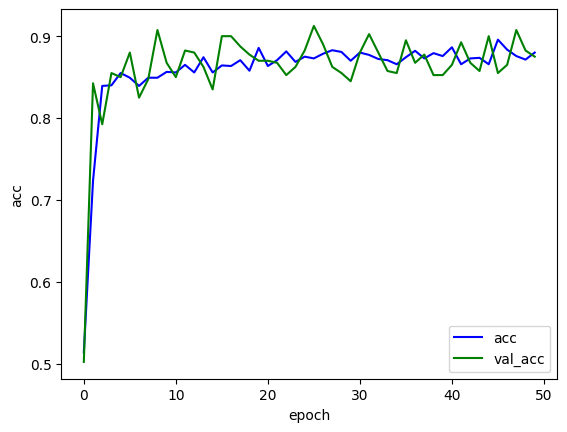

In [39]:
print('正解率：',val_acc_list[-1]*100, '%')

'''結果の表示'''
plt.plot(range(nepoch), loss_list, 'r-', label='train_loss')
plt.plot(range(nepoch), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure()
plt.plot(range(nepoch), acc_list, 'b-', label='acc')
plt.plot(range(nepoch), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')